In [2]:
import numpy as np
from netCDF4 import Dataset
import glob
import xarray
import os
import matplotlib.pyplot as plt
import typhon
import utils
from importlib import reload
from scipy.interpolate import interp1d
import datetime
import pandas
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams.update({'font.size': 15})
reload(utils)

<module 'utils' from '/Users/mprange/Desktop/bulletin/utils.py'>

# Read data 

In [3]:
plot_dir = '../plots'

platforms = ['BCO'] #e.g. BCO, RHB, M161 (Meteor), ATL (Atalante), MSM (Maria S Merian)
date_bnds = [datetime.datetime(2020, 1, 19), datetime.datetime(2020, 1, 19)]
time_period = ['0000', '2400'] #In UTC angeben, aber an lokaler Aufstiegszeit orientieren: 14:45 UTC u. 18:45 UTC entsprechen 10:45 u. 14:45 local time 
branches = ['ascending']
datapath = '/Users/mprange/Desktop/bulletin/data/Radiosondes/NC'
n_smooth = 10

profile_variables = ['altitude', 'pressure', 'temperature', 'humidity', 'mixingRatio',\
                     'windSpeed', 'windDirection', 'dewPoint']
attribute_variables = ['latitude', 'longitude', 'time_of_launch_HHmmss', 'date_YYYYMMDD', 'platform_name']
variables = profile_variables + attribute_variables

date_range = []

if date_bnds[1] == date_bnds[0]:
    date_range = [date_bnds[0]]
else:
    d = date_bnds[0]
    while d <= date_bnds[1]:
        d = d + datetime.timedelta(days=1)
        date_range.append(d)
dates = [d.strftime('%Y%m%d') for d in date_range]
start_time = time_period[0]
end_time = time_period[1]
filenames = utils.get_filenames(dates, start_time, end_time, platforms, branches, datapath)
# print(filenames)

profiles = []
for n, filename in enumerate(filenames):
    profiles.append(utils.profiles_from_netcdf(os.path.join(datapath, filename), variables))

# Calculate relevant quantities

In [6]:
reload(utils)
profiles_smoothed = utils.smooth_profiles(profiles, profile_variables, n_smooth)
for profile in profiles_smoothed:
    profile['launch_time'] = datetime.datetime(
        year = int(profile['date_YYYYMMDD'][0:4]),
        month = int(profile['date_YYYYMMDD'][4:6]),
        day = int(profile['date_YYYYMMDD'][6:8]),
        hour = int(profile['time_of_launch_HHmmss'][0:2]),
        minute = int(profile['time_of_launch_HHmmss'][2:4])
    )
    profile['vmr'] = typhon.physics.relative_humidity2vmr(
        profile['humidity'] * 1e-2,
        profile['pressure'] * 1e2,
        profile['temperature'] + 273.15    
    )
    profile['specific_humidity'] = typhon.physics.vmr2specific_humidity(
        profile['vmr']
    )
    profile['potTemp'] = utils.calc_potential_temperature(
        profile['temperature'] + 273.15,
        profile['pressure'] * 1e2
    )
    profile['virtPotTemp'] = utils.calc_virtual_potential_temperature(
        profile['temperature'] + 273.15,
        profile['mixingRatio'] * 1e-3,
        profile['pressure'] * 1e2
    )
    profile['lts'] = utils.calc_lower_tropospheric_stability(
        profile['temperature'] + 273.15,
        profile['pressure'] * 1e2
    )
    profile['lcl'] = utils.calc_lcl(
        profile['temperature'] + 273.15,
        profile['humidity'] * 1e-2,
        profile['altitude'],
        levels=slice(0, 3)
    )
    profile['lcl_bco'] = utils.calc_lcl_bco(
        profile['temperature'] + 273.15,
        profile['dewPoint'] + 273.15,
        profile['altitude'],
        levels=slice(0, 3)
    )
    profile['inversion_height'], profile['stability']\
    = utils.get_inversion_props(
        profile['temperature'] + 273.15,
        profile['specific_humidity'],
        profile['pressure'] * 1e2,
        profile['altitude'],
        min_pres=700e2,
        virtual=True
    )
    profile['iwv'] = utils.calc_integrated_water_vapor(
        profile['vmr'],
        profile['temperature'] + 273.15,
        profile['pressure'] * 1e2,
        profile['altitude']
    )
    profile['pw'] = utils.calc_precipitable_water(
        profile['vmr'],
        profile['temperature'] + 273.15,
        profile['pressure'] * 1e2,
        profile['altitude']
    )
    profile['eis'] = utils.calc_eis(
        profile['pressure'] * 1e2,
        profile['temperature'] + 273.15,
        profile['humidity'] * 1e-2,
        profile['altitude']
    )
    profile['speed3km'] = utils.layer_mean_speed(
        profile['windSpeed'],
        profile['altitude'],
        3000
    )
    profile['speed6km'] = utils.layer_mean_speed(
        profile['windSpeed'],
        profile['altitude'],
        6000
    )
    profile['speed9km'] = utils.layer_mean_speed(
        profile['windSpeed'],
        profile['altitude'],
        8000
    )
    profile['dir3km'] = utils.layer_mean_dir(
        profile['windDirection'],
        profile['windSpeed'],
        profile['altitude'],
        3000
    )
    profile['dir6km'] = utils.layer_mean_dir(
        profile['windDirection'],
        profile['windSpeed'],
        profile['altitude'],
        6000
    )
    profile['dir9km'] = utils.layer_mean_dir(
        profile['windDirection'],
        profile['windSpeed'],
        profile['altitude'],
        8000
    )
    profile['u3km'], profile['v3km'] = utils.calc_wind_components(
        profile['dir3km'],
        profile['speed3km'],
    )
    profile['u6km'], profile['v6km'] = utils.calc_wind_components(
        profile['dir6km'],
        profile['speed6km'],
    )
    profile['u9km'], profile['v9km'] = utils.calc_wind_components(
        profile['dir9km'],
        profile['speed9km'],
    )


profiles_smoothed = sorted(profiles_smoothed, key=lambda profile: profile['launch_time'])
heights = np.arange(0, 20e3, 4)
profiles_interp = utils.interpolate_profiles(profiles_smoothed, 
                                             ['pressure', 'temperature', 'humidity', 
                                              'mixingRatio', 'windSpeed', 'windDirection', 
                                              'dewPoint', 'specific_humidity', 'potTemp', 
                                              'virtPotTemp', 'stability'], heights)

# Print results

## Individual soundings

In [7]:
df = pandas.DataFrame.from_dict(
    profiles_smoothed).drop(
    profile_variables+['vmr', 'latitude', 'longitude', 
                       'time_of_launch_HHmmss', 'specific_humidity', 
                       'potTemp', 'virtPotTemp', 'stability'], axis=1)
df.head(20)

,date_YYYYMMDD,platform_name,launch_time,lts,lcl,lcl_bco,inversion_height,iwv,pw,eis,...,speed9km,dir3km,dir6km,dir9km,u3km,v3km,u6km,v6km,u9km,v9km
0,20200119,Barbados Cloud Observatory (BCO),2020-01-19 02:47:00,13.228368,788.783508,779.618391,2569.419995,31.020744,31.114086,2.787526,...,10.705842,252.502508,43.740318,311.981049,5.406680,1.704459,-4.459608,-4.660143,7.958360,-7.160975
1,20200119,Barbados Cloud Observatory (BCO),2020-01-19 06:45:00,11.909779,801.215452,792.028313,1424.499988,31.479395,31.574117,1.891327,...,11.375369,266.734532,59.047368,310.268191,2.710108,0.154625,-3.861278,-2.315747,8.679717,-7.352655
2,20200119,Barbados Cloud Observatory (BCO),2020-01-19 10:46:00,12.583564,871.804926,862.406646,3166.979980,29.227077,29.315022,2.464203,...,11.710315,217.857491,49.709229,328.494572,1.726672,2.221406,-1.313032,-1.113168,6.119569,-9.984106
3,20200119,Barbados Cloud Observatory (BCO),2020-01-19 14:44:00,15.094616,851.558533,842.240016,1503.200000,26.431714,26.511247,5.273917,...,12.366016,201.841425,244.073683,328.611481,2.456569,6.129006,1.264033,0.614499,6.440698,-10.556314
4,20200119,Barbados Cloud Observatory (BCO),2020-01-19 18:46:00,16.051734,833.027342,824.050031,1738.959985,29.599146,29.688211,5.962399,...,14.385709,199.136959,289.841036,326.642144,1.495674,4.310255,2.676958,-0.965931,7.910219,-12.015700
5,20200119,Barbados Cloud Observatory (BCO),2020-01-19 22:44:00,15.148106,619.413633,611.333372,1726.210010,30.998064,31.091338,3.842550,...,10.820902,196.432507,329.772922,328.365140,0.459928,1.559436,1.727546,-2.964997,5.675607,-9.213003


## Statistics

In [8]:
df.describe()

,lts,lcl,lcl_bco,inversion_height,iwv,pw,eis,speed3km,speed6km,speed9km,dir3km,dir6km,dir9km,u3km,v3km,u6km,v6km,u9km,v9km
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,14.002694,794.300566,785.279462,2021.544993,29.792690,29.882337,3.703654,3.998043,3.392833,11.894026,222.417570,169.364093,322.393763,2.375939,2.679864,-0.660897,-1.900915,7.130695,-9.380459
std,1.655091,91.048181,90.588190,693.456507,1.868666,1.874288,1.627698,1.927384,1.877373,1.363627,30.101425,132.737040,8.775421,1.683512,2.160951,3.021563,1.829740,1.208959,1.884551
min,11.909779,619.413633,611.333372,1424.499988,26.431714,26.511247,1.891327,1.625846,1.405485,10.705842,196.432507,43.740318,310.268191,0.459928,0.154625,-4.459608,-4.660143,5.675607,-12.015700
25%,12.744765,791.891494,782.720872,1558.952502,29.320094,29.408319,2.545034,2.739273,2.002519,10.959519,199.813075,52.043764,315.646323,1.553424,1.595692,-3.224217,-2.802684,6.199851,-10.413262
50%,14.161492,817.121397,808.039172,1732.584998,30.298605,30.389774,3.315038,3.687965,3.138730,11.542842,209.849458,151.560526,327.503642,2.091621,1.962933,-0.024499,-1.714458,7.175459,-9.598554
75%,15.134733,846.925735,837.692520,2361.804993,31.015074,31.108399,4.916075,5.392333,4.234736,12.202091,243.841254,278.399198,328.462214,2.646723,3.788043,1.611667,-1.002740,7.946325,-7.817742
max,16.051734,871.804926,862.406646,3166.979980,31.479395,31.574117,5.962399,6.602987,6.450197,14.385709,266.734532,329.772922,328.611481,5.406680,6.129006,2.676958,0.614499,8.679717,-7.160975


## Mean wind directions

In [9]:
dirs_3km = np.array([p['dir3km'] for p in profiles_smoothed])
dirs_6km = np.array([p['dir6km'] for p in profiles_smoothed])
dirs_9km = np.array([p['dir9km'] for p in profiles_smoothed])
speeds_3km = np.array([p['speed3km'] for p in profiles_smoothed])
speeds_6km = np.array([p['speed6km'] for p in profiles_smoothed])
speeds_9km = np.array([p['speed9km'] for p in profiles_smoothed])
u3, v3 = utils.calc_wind_components(dirs_3km, speeds_3km)
mean_dir_3km = utils.calc_wind_direction(np.mean(u3), np.mean(v3))
u6, v6 = utils.calc_wind_components(dirs_6km, speeds_6km)
mean_dir_6km = utils.calc_wind_direction(np.mean(u6), np.mean(v6))
u9, v9 = utils.calc_wind_components(dirs_9km, speeds_9km)
mean_dir_9km = utils.calc_wind_direction(np.mean(u9), np.mean(v9))

print(f'Wind direction 3km: {mean_dir_3km}°')
print(f'Wind direction 6km: {mean_dir_6km}°')
print(f'Wind direction 9km: {mean_dir_9km}°')

Wind direction 3km: 221.55984530625665°
Wind direction 6km: 19.17118650672643°
Wind direction 9km: 322.759178455448°


# Plot soundings

## Profiles vs. height up to 10km

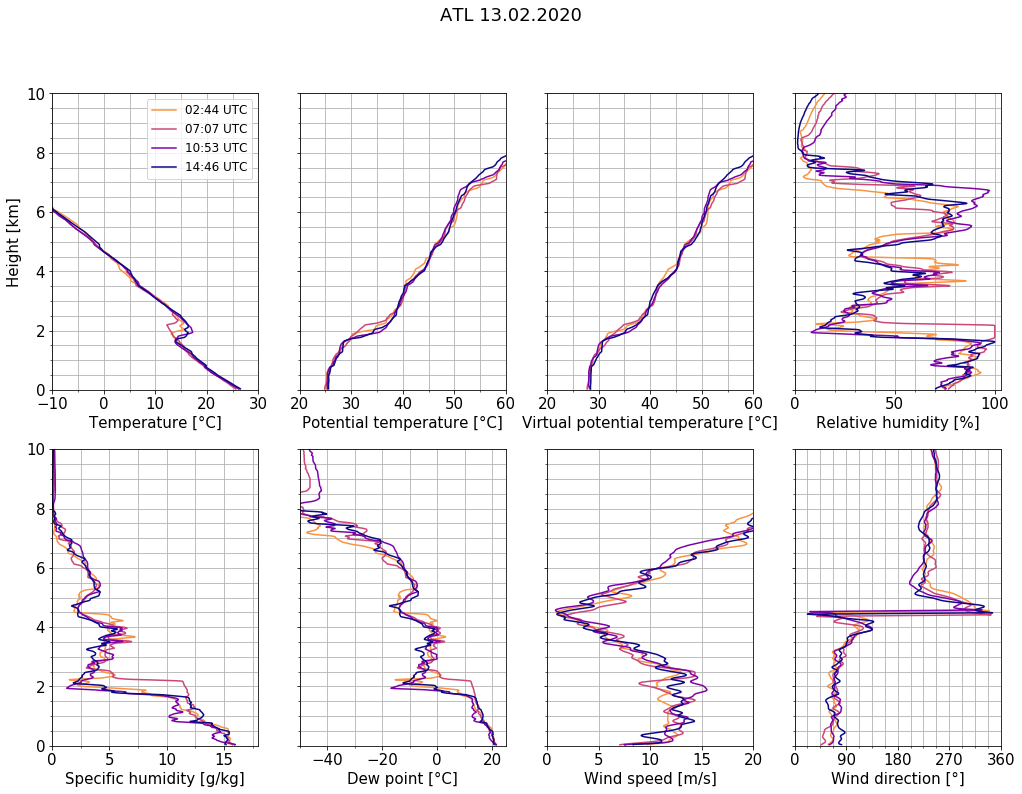

In [15]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(2, 4, figsize=(17, 12), sharey=True)
ax = ax.ravel()
colours = typhon.plots.cmap2rgba('plasma_r', len(profiles)+1)
for n, profile in enumerate(profiles_smoothed):
    hh = profile['time_of_launch_HHmmss'][0:2]
    mm = profile['time_of_launch_HHmmss'][2:4]
    launch_time = f'{hh}:{mm} UTC'
    ax[0].plot(profile['temperature'], profile['altitude'] * 1e-3, color=colours[n+1], label=launch_time)
    ax[1].plot(profile['potTemp'] - 273.15, profile['altitude'] * 1e-3, color=colours[n+1])
    ax[2].plot(profile['virtPotTemp'] - 273.15, profile['altitude'] * 1e-3, color=colours[n+1])
    ax[3].plot(profile['humidity'], profile['altitude'] * 1e-3, color=colours[n+1])
    ax[4].plot(profile['specific_humidity'] * 1e3, profile['altitude'] * 1e-3, color=colours[n+1])
    ax[5].plot(profile['dewPoint'], profile['altitude'] * 1e-3, color=colours[n+1])
    ax[6].plot(profile['windSpeed'], profile['altitude'] * 1e-3, color=colours[n+1])
    ax[7].plot(profile['windDirection'], profile['altitude'] * 1e-3, color=colours[n+1])
    #ax[7].plot(profile['stability'], profile['altitude'] * 1e-3, color=f'C{n}')
    ax[0].set_ylim(0, 10)  
    for i in range(5):
        xmin, xmax = ax[i].get_xlim() 
        #ax[i].hlines(profile['inversion_height'] * 1e-3, xmin, xmax, color=f'C{n}', lw=0.5)

ax[0].legend(fontsize=12)
ax[0].set_ylabel('Height [km]')
ax[0].set_xlabel('Temperature [°C]')
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].xaxis.set_minor_locator(MultipleLocator(5))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.25))
ax[0].grid(which='both')
ax[0].set_xlim(-10, 30)
ax[1].set_xlabel('Potential temperature [°C]')
ax[1].set_xlim(20, 60)
ax[1].xaxis.set_minor_locator(MultipleLocator(5))
ax[1].grid(which='both')
ax[2].set_xlabel('Virtual potential temperature [°C]')
ax[2].set_xlim(20, 60)
ax[2].xaxis.set_minor_locator(MultipleLocator(5))
ax[2].grid(which='both')
ax[3].set_xlabel('Relative humidity [%]')
ax[3].set_xlim(0, 103)
ax[3].xaxis.set_minor_locator(MultipleLocator(10))
ax[3].grid(which='both')
ax[4].set_xlabel('Specific humidity [g/kg]')
ax[4].set_xlim(0, 18)
ax[4].xaxis.set_minor_locator(MultipleLocator(2.5))
ax[4].grid(which='both')
ax[5].set_xlim(-50, 25)
ax[5].xaxis.set_minor_locator(MultipleLocator(10))
ax[5].grid(which='both')
ax[5].set_xlabel('Dew point [°C]')
ax[6].set_xlabel('Wind speed [m/s]')
ax[6].set_xlim(0, 20)
ax[6].grid(which='both')
ax[7].set_xlim(0, 360)
ax[7].set_xlabel('Wind direction [°]')
ax[7].grid(which='both')
ax[7].xaxis.set_minor_locator(MultipleLocator(30))
ax[7].xaxis.set_major_locator(MultipleLocator(90))
plt.minorticks_on()
date = date_range[0].strftime('%d.%m.%Y')
fig.suptitle(f'{platforms[0]} {date}')
plt.savefig(os.path.join(plot_dir, f'Soundings_{platforms[0]}_{dates[0]}.pdf'))